In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

pd.set_option('display.width', None)
pd.set_option('display.max_columns', None) 

%load_ext autoreload
%autoreload 2
import logging
logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
df = pd.read_csv('../data/Iris.csv')

-----

In [5]:
from mlbox.preprocessing import Reader, Drift_thresholder
from mlbox.optimisation import Optimiser
from mlbox.prediction import Predictor

In [6]:
def remove_ids(df):
    df = df.copy()
    cols_drop = [col for col in df.select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns if df[col].diff().dropna().eq(1).all()]
    return df.drop(columns = cols_drop)

In [7]:
def train_test_split_wrapper(data_path, target_name, train, test, y_test):
    path = '/'.join(data_path.split('/')[:-1])
    train.to_csv(f'{path}/train.csv')
    test.to_csv(f'{path}/test.csv')

    paths = [f'{path}/train.csv',f'{path}/test.csv']

    rd = Reader(sep = ",")
    df = rd.train_test_split(paths, target_name)
    
    if (y_test.dtype == 'object'):
        df['target_test'] = pd.Series(y_test)
        df['target_test'] = LabelEncoder().fit_transform(df['target_test'])
        return df

    elif (y_test.dtype=='int' or y_test.dtype=='float'):
        df['target_test'] = pd.Series(y_test)
        return df

In [8]:
path = '/'.join('data/Iris.csv'.split('/')[:-1])

In [9]:
path

'data'

In [13]:
def split_data(datapath, target_name, train_test_ratio=0.7, stratified=True):
    df = pd.read_csv(datapath).pipe(remove_ids)

    if stratified :
        X = df.drop(columns=target_name)
        y = df[target_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=train_test_ratio)
        train = pd.concat([X_train, y_train], axis=1)
        
        return train, X_test, y_test

    elif not stratified:

        train, test = np.split(df, [int(train_test_ratio * len(df))])
        y_test = test[target_name]
        X_test = test.drop(columns=[target_name])
        
        return train, X_test, y_test

In [14]:
def get_train_test_data(data_path, target_name, train_test_ratio=0.7, stratified=True):
    df_train, df_test, y_test = split_data(data_path, target_name, train_test_ratio, stratified)
    return train_test_split_wrapper(data_path, target_name, df_train, df_test, y_test)

In [15]:
df = get_train_test_data('../data/Iris.csv', 'Species', 0.70, stratified=True)


reading csv : train.csv ...
cleaning data ...
CPU time: 19.21494197845459 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 13.921379089355469 seconds

> Number of common features : 4

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 4
> Number of training samples : 104
> Number of test samples : 45

> You have no missing values on train set...

> Task : classification
Iris-setosa        35
Iris-versicolor    35
Iris-virginica     34
Name: Species, dtype: int64

encoding target ...


-----

In [16]:
df

{'train':      PetalLengthCm  PetalWidthCm  SepalLengthCm  SepalWidthCm
 0              5.4           2.3            6.2           3.4
 1              1.5           0.4            5.1           3.7
 2              4.4           1.4            6.6           3.0
 3              3.5           1.0            5.7           2.6
 4              1.4           0.2            5.1           3.5
 ..             ...           ...            ...           ...
 100            4.0           1.3            5.5           2.3
 101            6.7           2.0            7.7           2.8
 102            4.7           1.4            7.0           3.2
 103            1.6           0.2            5.1           3.8
 104            4.0           1.0            6.0           2.2
 
 [104 rows x 4 columns],
 'test':     PetalLengthCm  PetalWidthCm  SepalLengthCm  SepalWidthCm
 0             4.7           1.4            6.1           2.9
 1             5.7           2.3            6.9           3.2
 2            

In [17]:
class NumericalDrifter(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.6):
        self.threshold = threshold
        self.dft = Drift_thresholder(threshold=self.threshold)

    def fit(self, df):
        return self

    def transform(self, df):
        return self.dft.fit_transform(df)

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

In [19]:
class CategoricalDrifter(BaseEstimator, TransformerMixin):
    
    def fit(self, df):
        df_temp = self.generate_temp_dataframe(df['train'], df['test'])
        self.drifted_cat_cols_ = self.chi_square_test(df_temp)  
        return self
        
        
    def transform(self, df):
        df['train'].drop(columns=self.drifted_cat_cols_)
        df['test'].drop(columns=self.drifted_cat_cols_)

        return df
        
    
    @staticmethod
    def get_categorical_columns(X):
        return list(X.select_dtypes(include=['category', 'object']).columns)
    
    
    @staticmethod
    def generate_temp_dataframe(train, test):
        train, test = train.copy(), test.copy()

        train = train.assign(type_df =  'train')
        test = test.assign(type_df = 'test')

        return pd.concat([train, test])
    
    
    
    def chi_square_test(self, df):
        cat_cols = [col for col in self.get_categorical_columns(df)]
        cat_cols.remove('type_df')
        drift_cols = []

        for col in cat_cols:
            c, p, dof, expected = chi2_contingency(pd.crosstab(df[col], df['type_df']))

            if p < 0.05:
                drift_cols.append(col)

        return drift_cols

In [20]:
class HighCardinalityRemover(TransformerMixin, BaseEstimator):
    def __init__(self, max_cardinality=0.9):
        self.max_cardinality = max_cardinality

    def fit(self, df):
        X = df['train']

        columns = self.get_categorical_columns(X)

        self.columns_to_drop_ = X[columns].nunique()[lambda x: (x / len(df)) < self.max_cardinality].index
        return self

    def transform(self, df):
        df = df.copy()
        df['train'].drop(columns=self.columns_to_drop_)
        df['test'].drop(columns=self.columns_to_drop_)

        return df

    @staticmethod
    def get_categorical_columns(X):
        return list(X.select_dtypes(include=['category', 'object']).columns)

In [21]:
# class Preprocess(TransformerMixin, BaseEstimator):
    
#     def __init__(self, numerical_drift_threshold=0.6, max_cardinality=0.9):
#         self.numerical_drift_threshold = numerical_drift_threshold
#         self.max_cardinality = max_cardinality
    
#     def fit(self, df):
#         self.pipeline = make_pipeline(
#             NumericalDrifter(threshold=self.numerical_drift_threshold),
#             CategoricalDrifter(),
#             HighCardinalityRemover(max_cardinality=self.max_cardinality)
#         )
        
#         self.pipeline.fit(df['train'])
        
#         return self
    
    
#     def transform(self, df):
#         df = df.copy()
#         return self.pipeline.transform(df)

In [22]:
class Preprocess:
    
    def __init__(self, numerical_drift_threshold=0.6, max_cardinality=0.9):
        self.numerical_drift_threshold = numerical_drift_threshold
        self.max_cardinality = max_cardinality
    
    def fit_transform(self, df):
        y_test = df['target_test']
        df = df.copy()
        df = NumericalDrifter(self.numerical_drift_threshold).fit_transform(df)
        df = CategoricalDrifter().fit_transform(df)
        df = HighCardinalityRemover(self.max_cardinality).fit_transform(df)
        df['target_test']=y_test
        
        return df 

In [20]:
preprocess = Preprocess(0.2, 0.9)

In [21]:
preprocess.fit_transform(df)


computing drifts ...
CPU time: 9.517056703567505 seconds

> Top 10 drifts

('SepalLengthCm', 0.14504378826629472)
('SepalWidthCm', 0.10598310470433248)
('PetalLengthCm', 0.04673331783306223)
('PetalWidthCm', 0.010908315895528098)

> Deleted variables : []
> Drift coefficients dumped into directory : save


{'train':      PetalLengthCm  PetalWidthCm  SepalLengthCm  SepalWidthCm
 0              4.4           1.4            6.6           3.0
 1              5.9           2.1            7.1           3.0
 2              5.0           1.9            6.3           2.5
 3              5.4           2.3            6.2           3.4
 4              4.9           1.8            6.1           3.0
 ..             ...           ...            ...           ...
 100            1.4           0.2            5.0           3.6
 101            4.2           1.5            5.9           3.0
 102            4.3           1.3            6.2           2.9
 103            5.9           2.3            6.8           3.2
 104            6.3           1.8            7.3           2.9
 
 [102 rows x 4 columns],
 'test':     PetalLengthCm  PetalWidthCm  SepalLengthCm  SepalWidthCm
 0             6.9           2.3            7.7           2.6
 1             5.7           2.5            6.7           3.3
 2            

-----

In [22]:
opt = Optimiser(scoring = "accuracy", n_folds = 5)

In [23]:
# space = {
#         'ne__numerical_strategy':{"search":"choice",
#                                  "space":[0, "mean"]},
#         'ce__strategy':{"search":"choice",
#                         "space":["label_encoding", "random_projection", "entity_embedding"]}, 
#         'fs__threshold':{"search":"uniform",
#                         "space":[0.001, 0.2]}, 
#         'est__strategy':{"search":"choice", 
#                          "space":["RandomForest", "ExtraTrees", "LightGBM"]},
#         'est__max_depth':{"search":"choice", 
#                           "space":[8, 9, 10, 11, 12, 13]}
#         }

In [24]:
space = {
    
        'est__strategy':{"search":"choice",
                                  "space":["LightGBM"]},    
        'est__n_estimators':{"search":"choice",
                                  "space":[150]},    
        'est__colsample_bytree':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__subsample':{"search":"uniform",
                                  "space":[0.8,0.95]},
        'est__max_depth':{"search":"choice",
                                  "space":[5,6,7,8,9]},
        'est__learning_rate':{"search":"choice",
                                  "space":[0.07]} 
    
        }

Optimises hyper-parameters of the whole Pipeline.

- NA encoder (missing values encoder)
- CA encoder (categorical features encoder)
- Feature selector (OPTIONAL)
- Stacking estimator - feature engineer (OPTIONAL)
- Estimator (classifier or regressor)

In [25]:
params = opt.optimise(space, df, 15)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002103 seconds
INFO:hyperopt.tpe:TPE using 0 trials


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}
>>> CA ENCODER :{'strategy': 'label_encoding'}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.807143220929002, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8470967812207807, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_job

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002823 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8282673199077302, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8000140577900032, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002222 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8930586110371672, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8136284825598001, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002077 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9029282454618177, 'learning_rate': 0.07, 'max_depth': 9, 'n_estimators': 150, 'subsample': 0.8266088923959652, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002086 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.913981461079943, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.9149503078804927, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1,

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002121 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8640829449016743, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.8020262807796709, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002175 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8917432611316152, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.8395723350302119, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002227 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8417382501368501, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8856374481301099, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002041 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8333992240371554, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8659847623606401, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002158 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'} 
>>> CA ENCODER :{'strategy': 'label_encoding'}                                   
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8003566198859351, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.8476385387424978, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002079 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9027216618260354, 'learning_rate': 0.07, 'max_depth': 9, 'n_estimators': 150, 'subsample': 0.9157017014384924, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002019 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8165751986522091, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8830536691304094, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002101 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8228851509080696, 'learning_rate': 0.07, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.8693921898606048, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001976 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.9054679324497487, 'learning_rate': 0.07, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.89194700457331, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001968 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.920952


##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}  
>>> CA ENCODER :{'strategy': 'label_encoding'}                                    
>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.8933704070559303, 'learning_rate': 0.07, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8835077757114251, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=

In [28]:
params

{'est__colsample_bytree': 0.807143220929002,
 'est__learning_rate': 0.07,
 'est__max_depth': 5,
 'est__n_estimators': 150,
 'est__strategy': 'LightGBM',
 'est__subsample': 0.8470967812207807}

In [29]:
opt.evaluate(params, df)


##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'colsample_bytree': 0.807143220929002, 'learning_rate': 0.07, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8470967812207807, 'boosting_type': 'gbdt', 'class_weight': None, 'importance_type': 'split', 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}

[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-

0.9209523809523809


fitting the pipeline ...
[LightGBM] [Warning] num_threads is set with nthread=-1, will be overridden by n_jobs=-1. Current value: num_threads=-1
CPU time: 0.03928112983703613 seconds


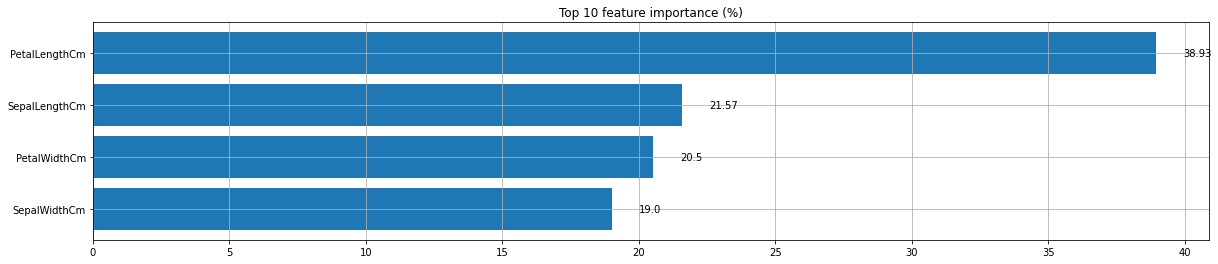


> Feature importances dumped into directory : save

predicting ...
CPU time: 0.023992061614990234 seconds

> Overview on predictions : 

   Iris-setosa  Iris-versicolor  Iris-virginica Species_predicted
0     0.999197         0.000801        0.000002       Iris-setosa
1     0.000076         0.006786        0.993138    Iris-virginica
2     0.000038         0.003460        0.996502    Iris-virginica
3     0.000042         0.968012        0.031946   Iris-versicolor
4     0.000018         0.004719        0.995262    Iris-virginica
5     0.999326         0.000672        0.000001       Iris-setosa
6     0.999773         0.000225        0.000001       Iris-setosa
7     0.999773         0.000225        0.000001       Iris-setosa
8     0.999730         0.000269        0.000002       Iris-setosa
9     0.999888         0.000099        0.000013       Iris-setosa

dumping predictions into directory : save ...


In [59]:
prd = Predictor()
prd.fit_predict(params, df)

# TPOT

In [10]:
from ipywidgets import IntProgress

In [11]:
preprocess = Preprocess(0.2, 0.9)

NameError: name 'Preprocess' is not defined

In [ ]:
df = preprocess.fit_transform(df)

In [12]:
from sklearn.model_selection import cross_val_score

In [51]:
from tpot import TPOTClassifier

In [52]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)

In [53]:
tpot.fit(df['train'], df['target'])

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9709523809523809

Generation 2 - Current best internal CV score: 0.9709523809523809

Generation 3 - Current best internal CV score: 0.9709523809523809

Generation 4 - Current best internal CV score: 0.9709523809523809

Generation 5 - Current best internal CV score: 0.9709523809523809

Best pipeline: MLPClassifier(input_matrix, alpha=0.0001, learning_rate_init=0.001)


TPOTClassifier(generations=5, population_size=50, random_state=42, verbosity=2)

In [72]:
tpot.fitted_pipeline_

Pipeline(steps=[('mlpclassifier', MLPClassifier(random_state=42))])

In [71]:
tpot.fitted_pipeline_.get_params()

{'memory': None,
 'steps': [('mlpclassifier', MLPClassifier(random_state=42))],
 'verbose': False,
 'mlpclassifier': MLPClassifier(random_state=42),
 'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__batch_size': 'auto',
 'mlpclassifier__beta_1': 0.9,
 'mlpclassifier__beta_2': 0.999,
 'mlpclassifier__early_stopping': False,
 'mlpclassifier__epsilon': 1e-08,
 'mlpclassifier__hidden_layer_sizes': (100,),
 'mlpclassifier__learning_rate': 'constant',
 'mlpclassifier__learning_rate_init': 0.001,
 'mlpclassifier__max_fun': 15000,
 'mlpclassifier__max_iter': 200,
 'mlpclassifier__momentum': 0.9,
 'mlpclassifier__n_iter_no_change': 10,
 'mlpclassifier__nesterovs_momentum': True,
 'mlpclassifier__power_t': 0.5,
 'mlpclassifier__random_state': 42,
 'mlpclassifier__shuffle': True,
 'mlpclassifier__solver': 'adam',
 'mlpclassifier__tol': 0.0001,
 'mlpclassifier__validation_fraction': 0.1,
 'mlpclassifier__verbose': False,
 'mlpclassifier__warm_start': False}

In [60]:
cross_val = cross_val_score(tpot.fitted_pipeline_, df['train'], df['target'], scoring='accuracy', cv=5).mean()

In [61]:
cross_val

0.9709523809523809

In [54]:
tpot.fitted_pipeline_.predict(df['train'])

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 1, 0, 1, 2, 0,
       2, 0, 0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 1, 0, 2, 1,
       0, 2, 2, 1, 1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1, 2, 1, 1, 2,
       1, 2, 2, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 2, 2, 0, 0, 2, 1, 2, 1, 0,
       2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 2, 2])

In [46]:
tpot.score(df['train'], df['target'])

0.9705882352941176

In [47]:
tpot.predict(df['test'])

array([2, 2, 2, 1, 1, 0, 2, 1, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 2, 1, 0, 2,
       2, 1, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 0, 1, 0, 0, 2, 2, 0, 1,
       1])

In [48]:
print(tpot.score(df['test'], df['target_test']))

1.0


# Pipeline

In [94]:
import operator

In [105]:
result = {'MLBox': {'cross_val': 0.98, 'parameters': {'a': 4}}, 'Tpot': {'cross_val': 0.99, 'parameters': {'a': 4}}}

In [106]:
result

{'MLBox': {'cross_val': 0.98, 'parameters': {'a': 4}},
 'Tpot': {'cross_val': 0.99, 'parameters': {'a': 4}}}

In [107]:
highest_score = 0
for k,v in result.items():
    if v['cross_val'] > highest_score:
        highest_score = v['cross_val']
        key = k

In [108]:
key

'Tpot'

In [110]:
result[key]['parameters']

{'a': 4}